In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('HuGaDB_v2_various_01_00.csv')

# Remoção manual de atributos irrelevantes para análise do movimento humano

df = df.drop(df.columns[0], axis=1)
df = df.drop(['EMG_right', 'EMG_left'], axis=1)

print(df.info())
print(df.describe())
print(df['activity'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   accelerometer_right_foot_x   2435 non-null   int64 
 1   accelerometer_right_foot_y   2435 non-null   int64 
 2   accelerometer_right_foot_z   2435 non-null   int64 
 3   gyroscope_right_foot_x       2435 non-null   int64 
 4   gyroscope_right_foot_y       2435 non-null   int64 
 5   gyroscope_right_foot_z       2435 non-null   int64 
 6   accelerometer_right_shin_x   2435 non-null   int64 
 7   accelerometer_right_shin_y   2435 non-null   int64 
 8   accelerometer_right_shin_z   2435 non-null   int64 
 9   gyroscope_right_shin_x       2435 non-null   int64 
 10  gyroscope_right_shin_y       2435 non-null   int64 
 11  gyroscope_right_shin_z       2435 non-null   int64 
 12  accelerometer_right_thigh_x  2435 non-null   int64 
 13  accelerometer_right_thigh_y  2435

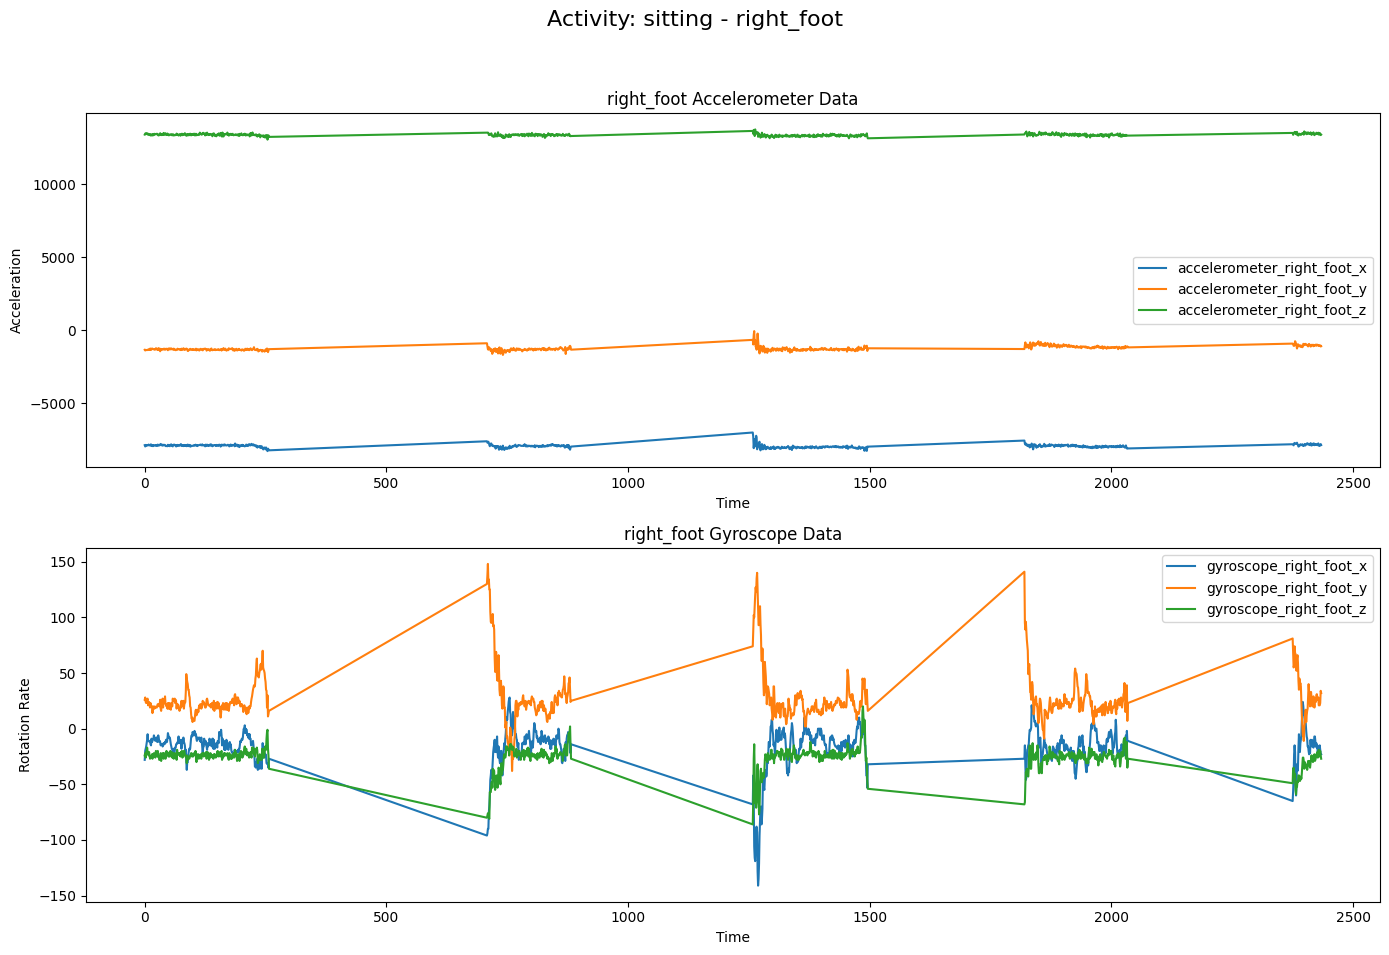

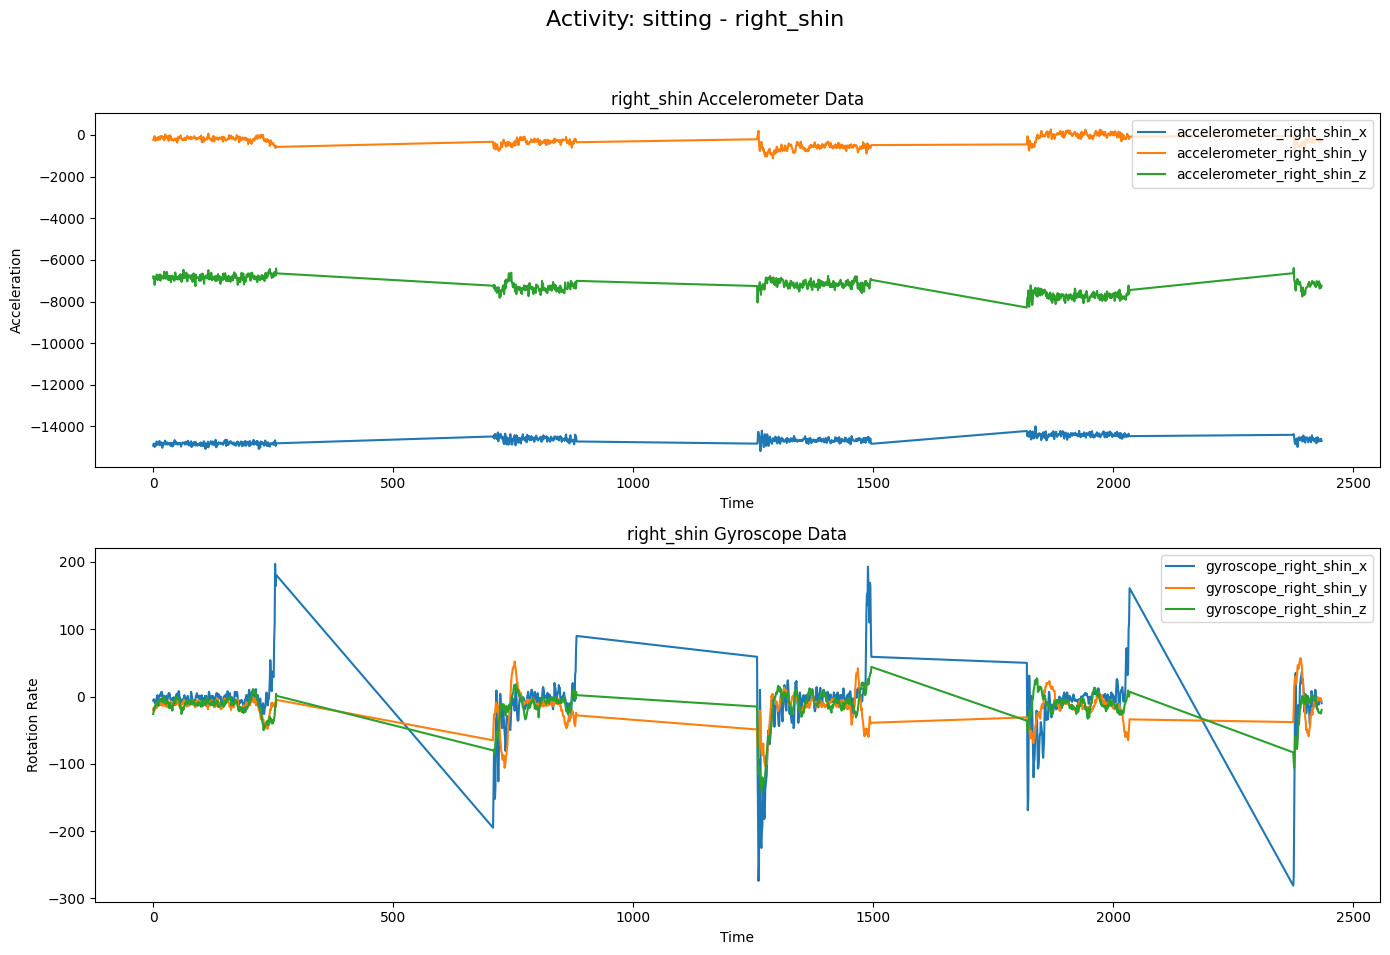

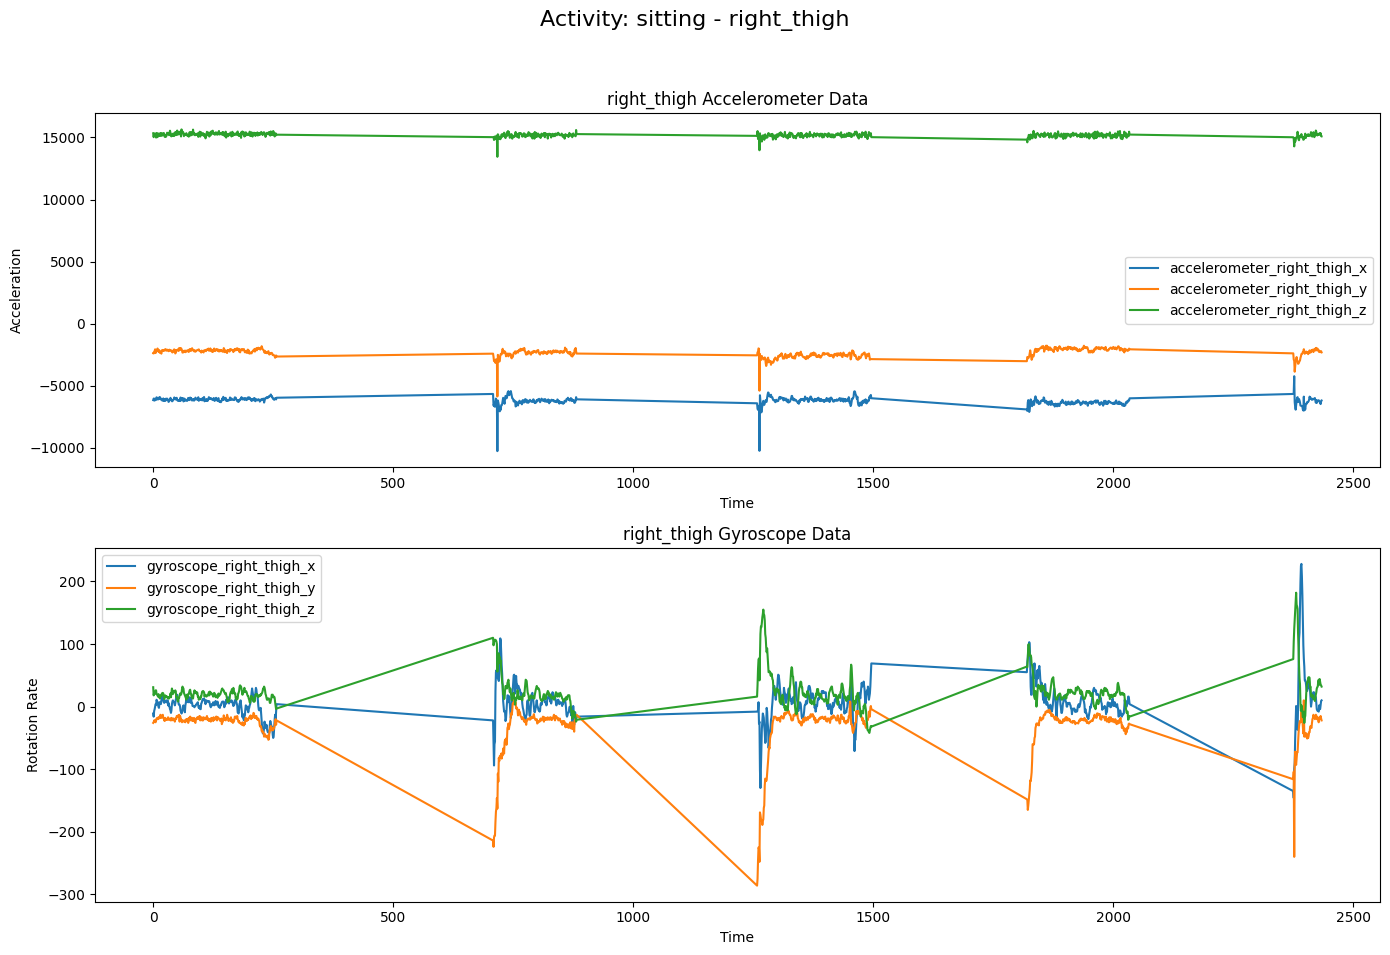

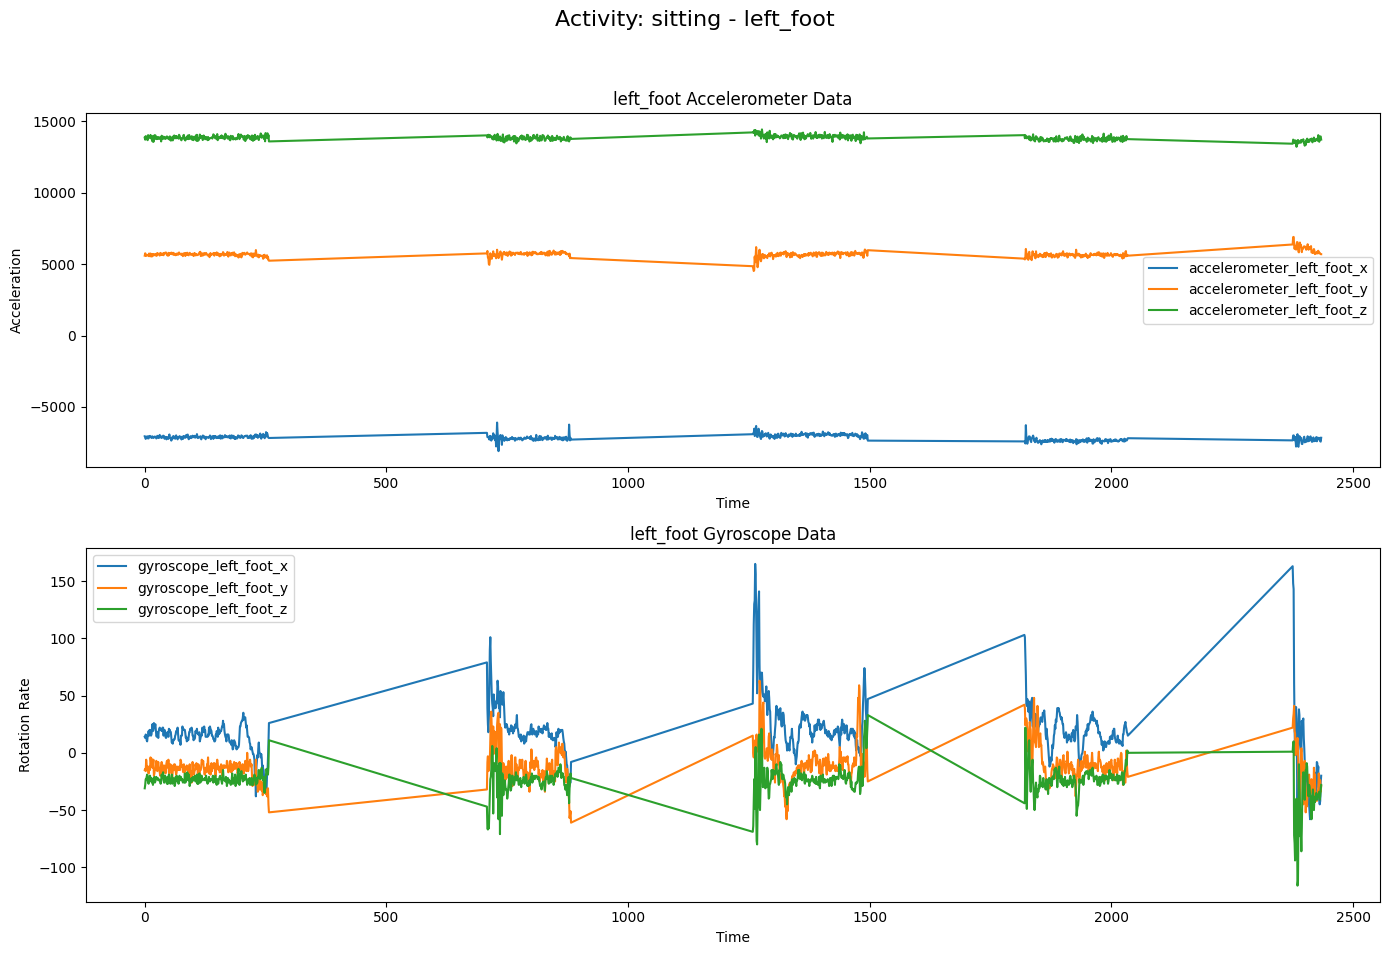

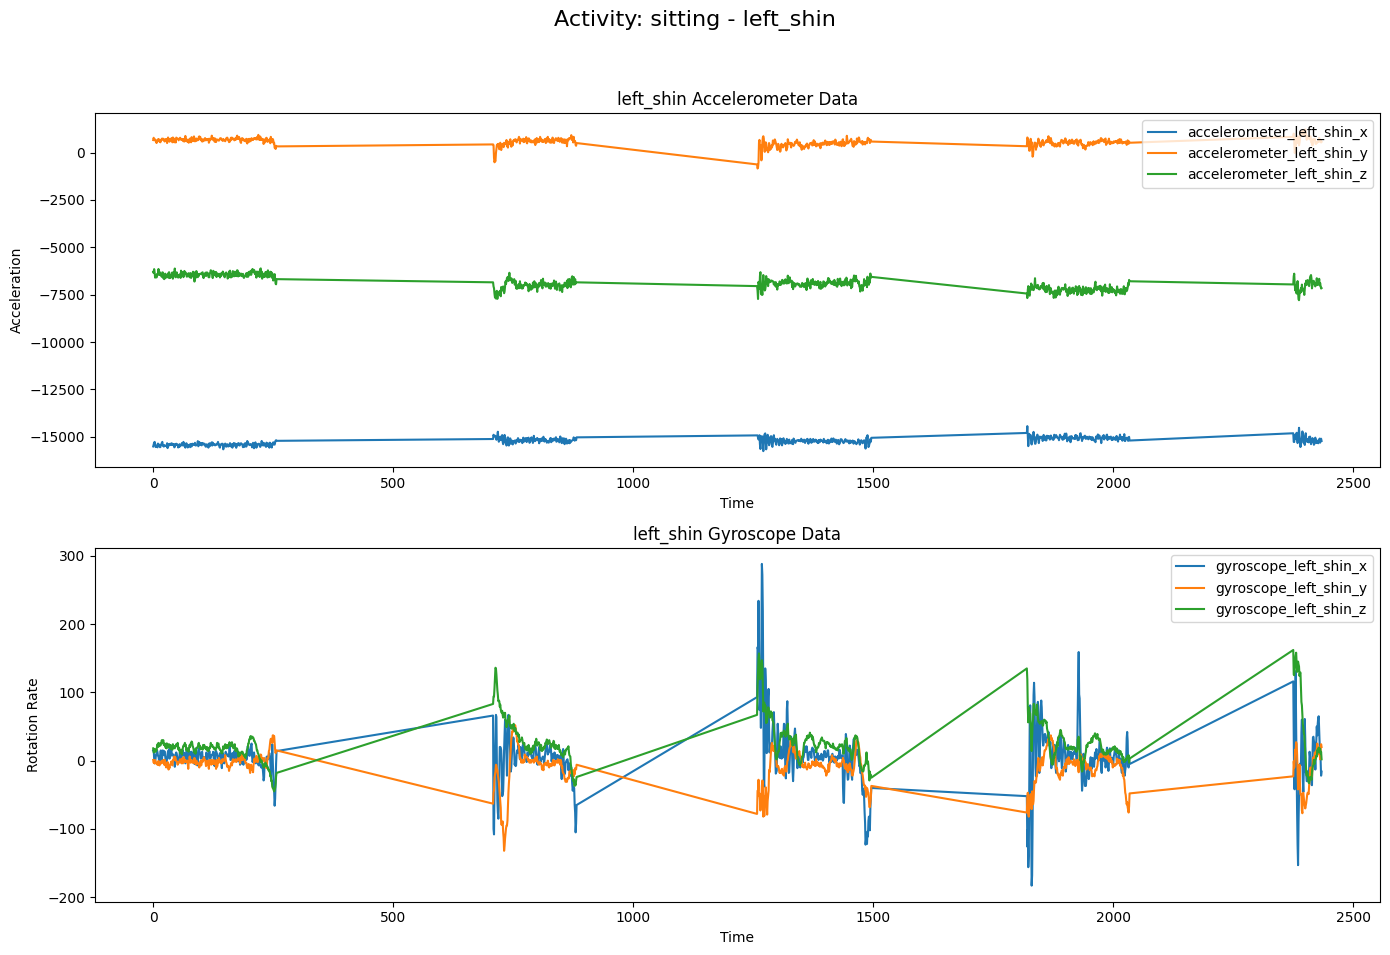

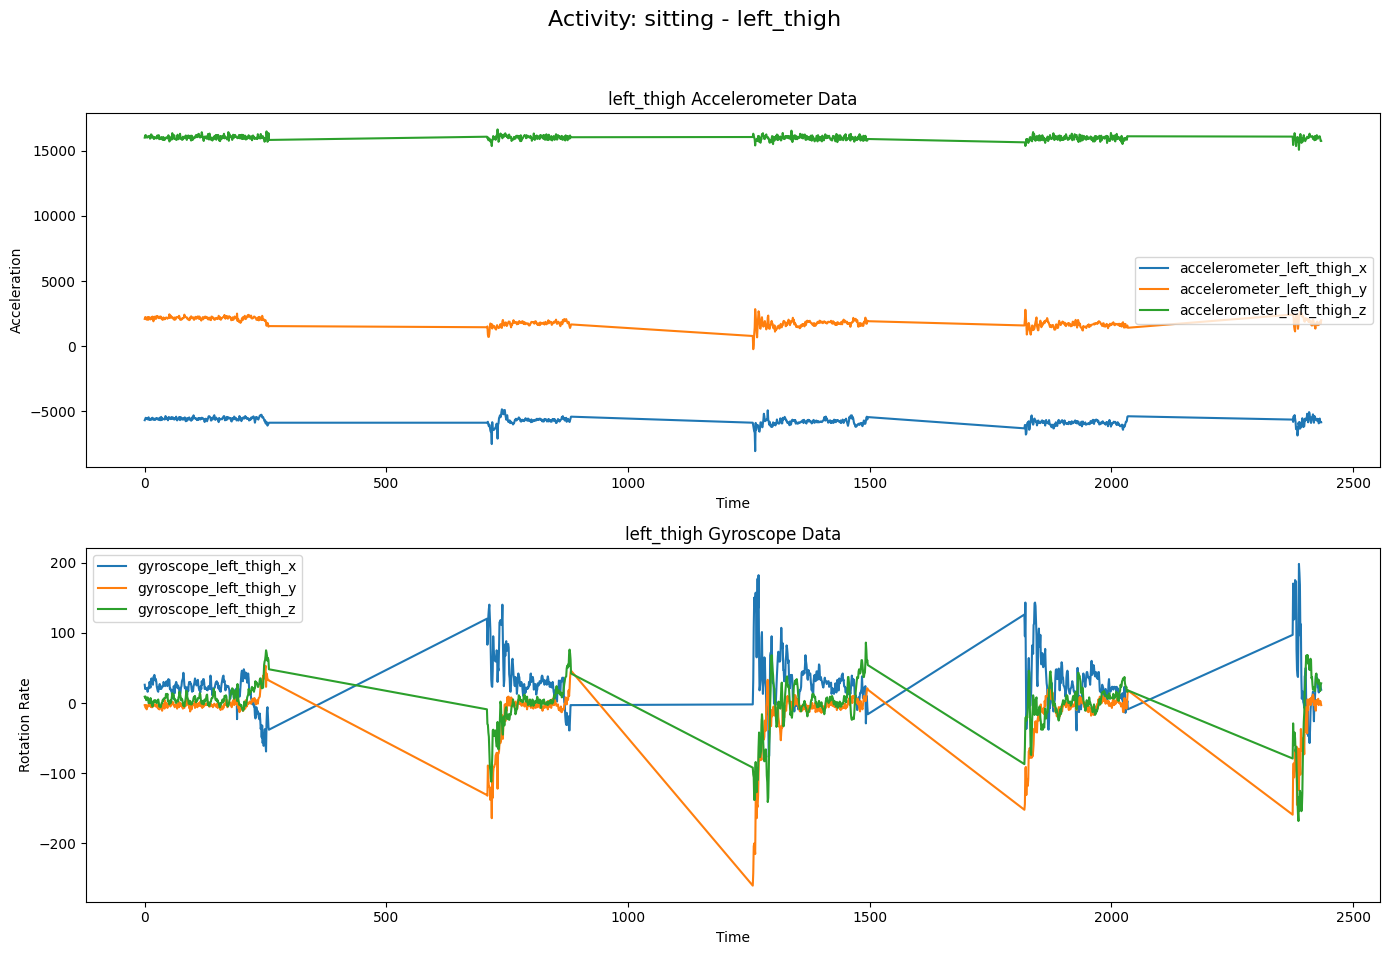

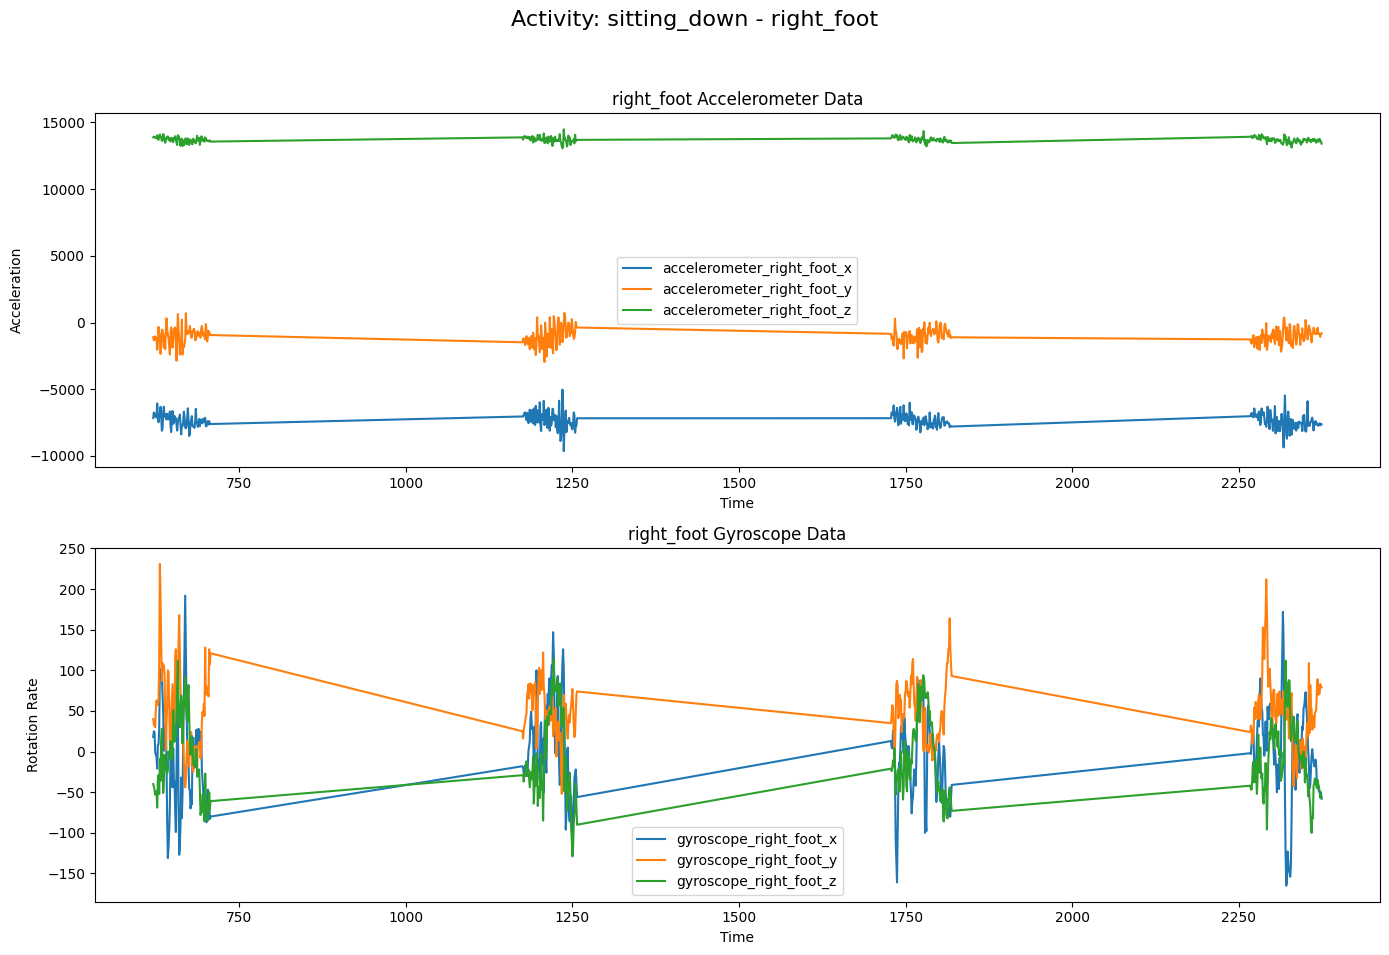

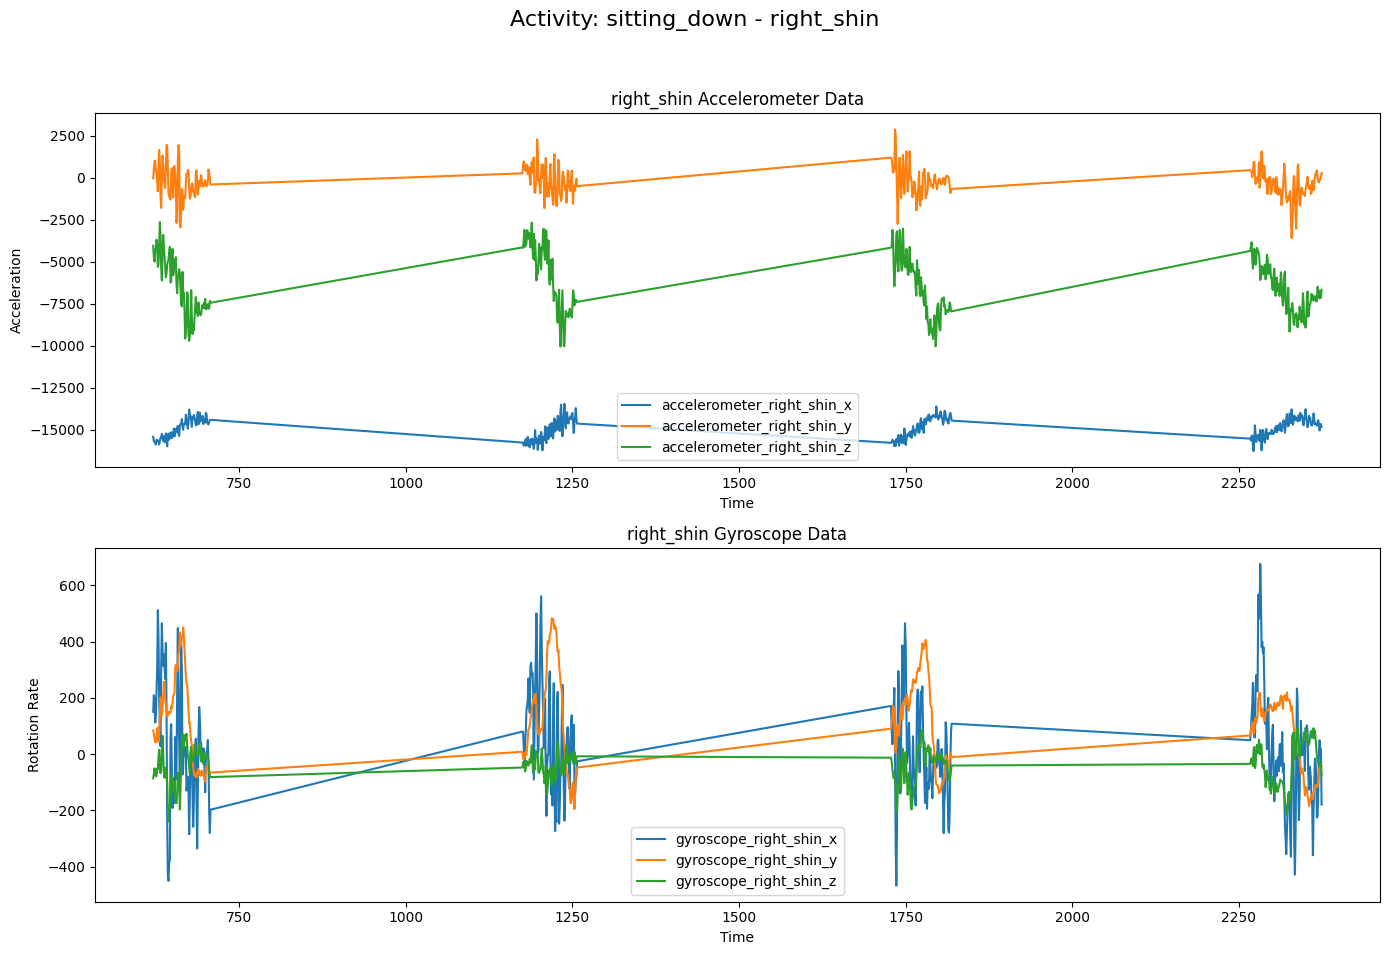

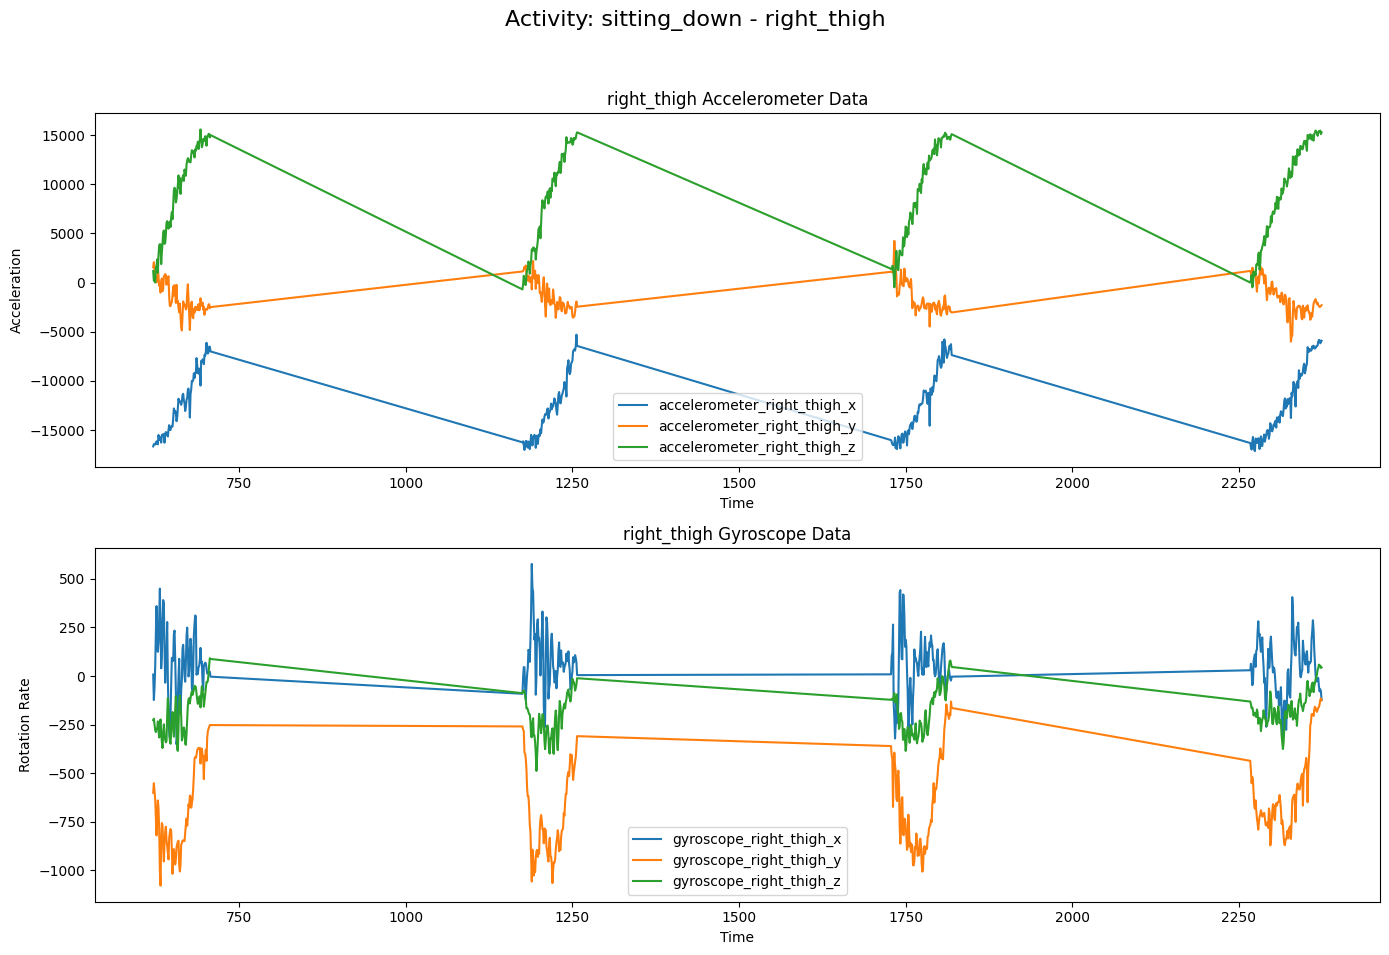

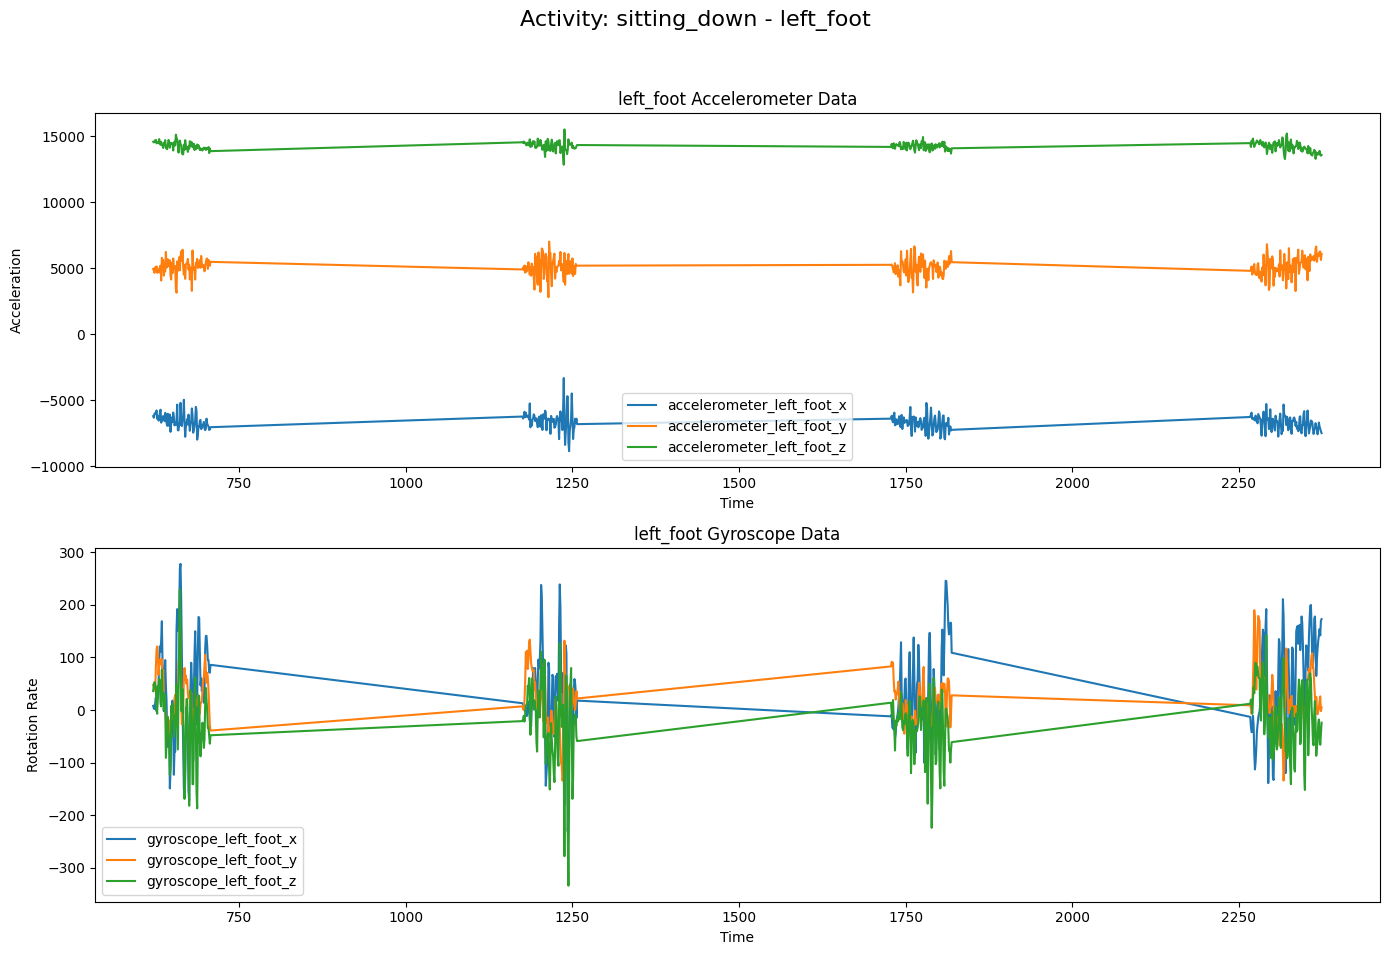

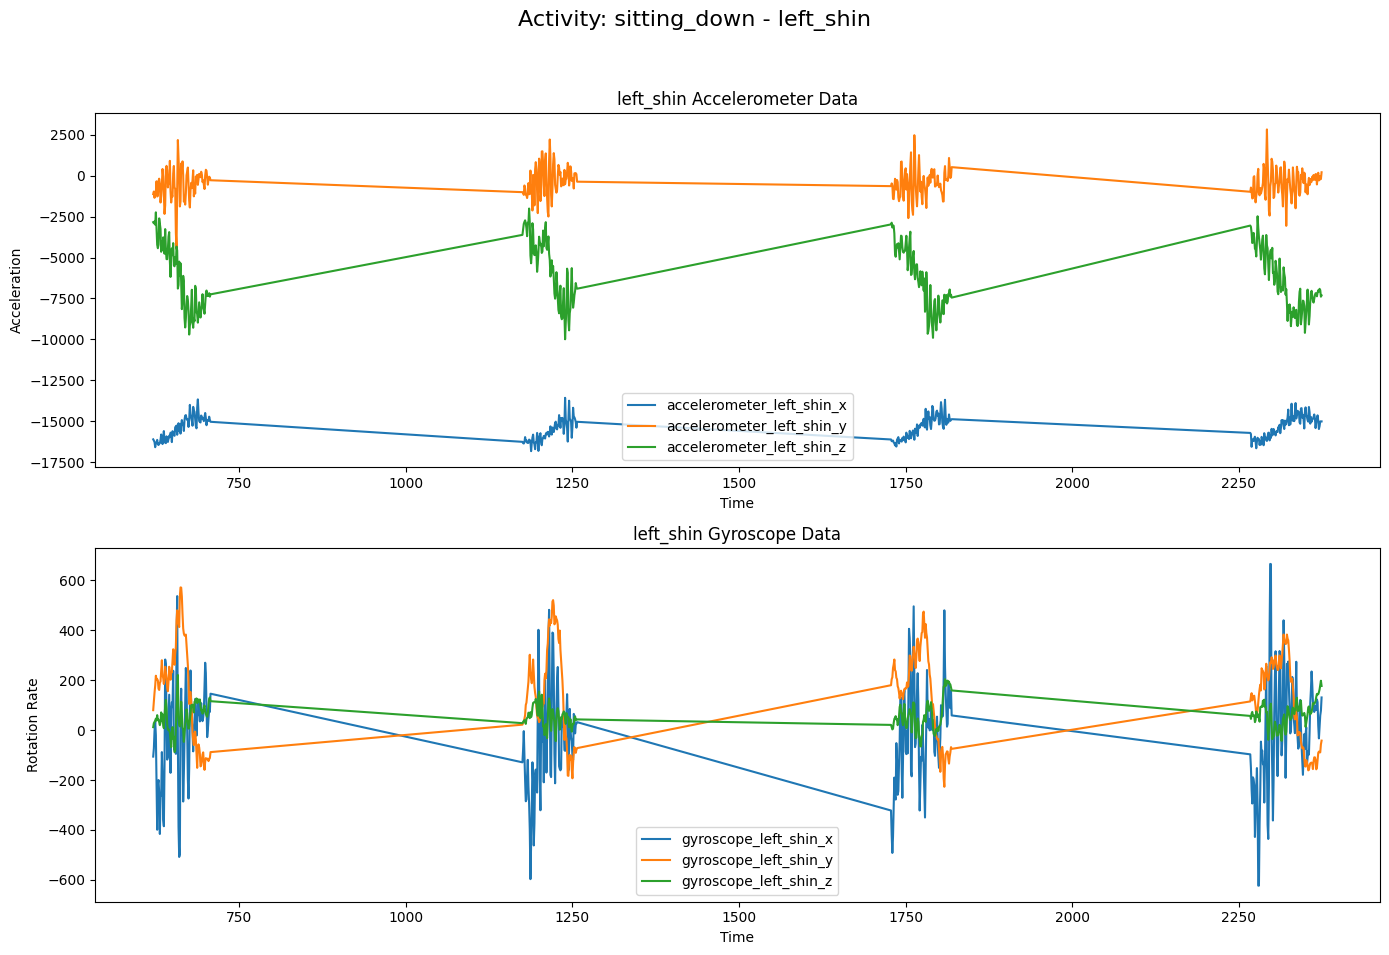

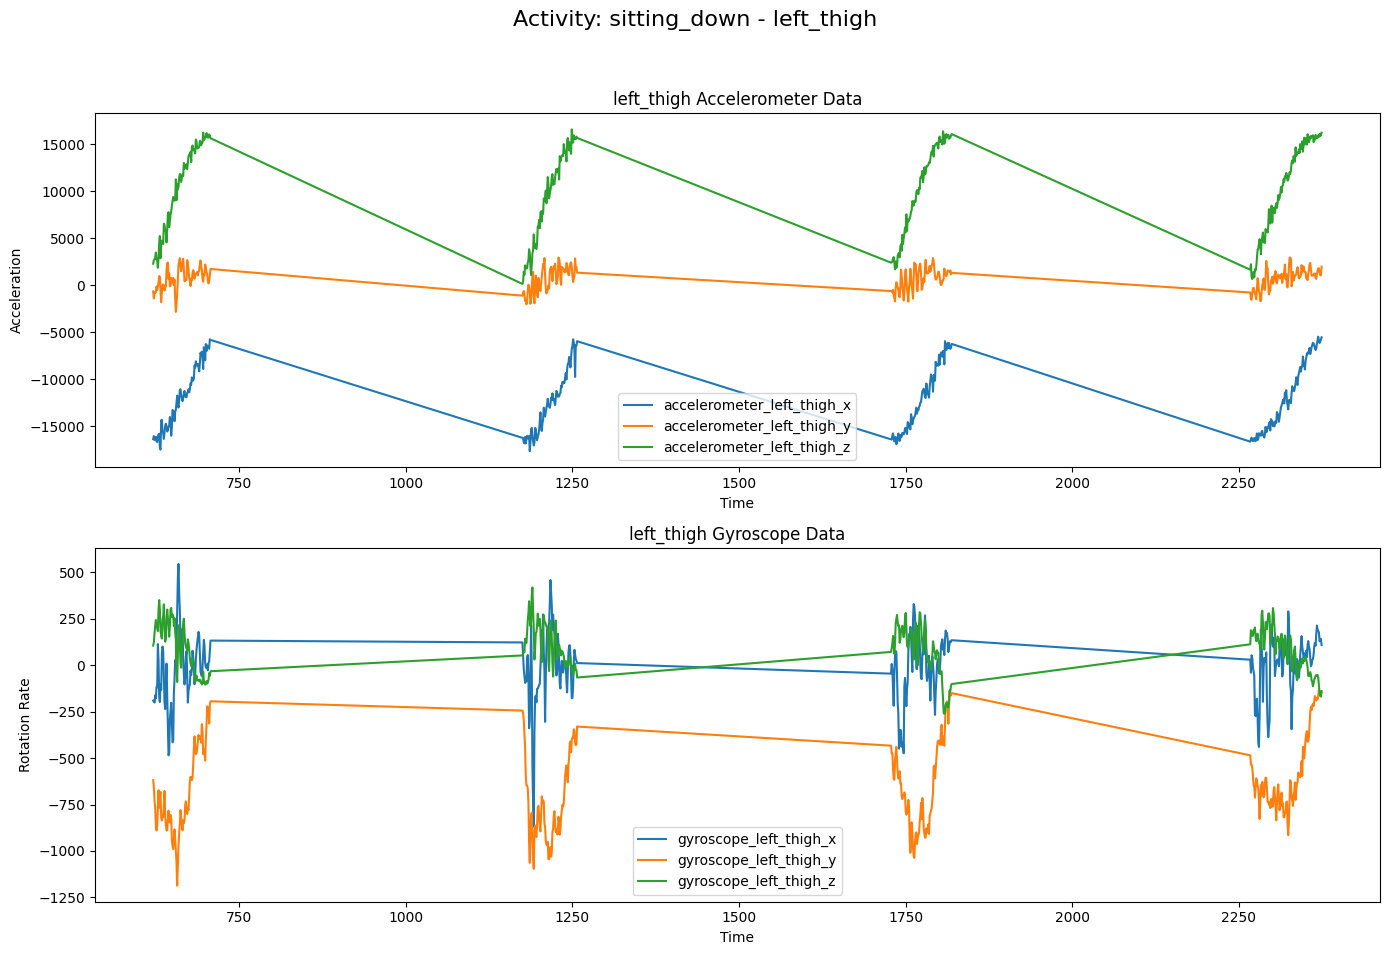

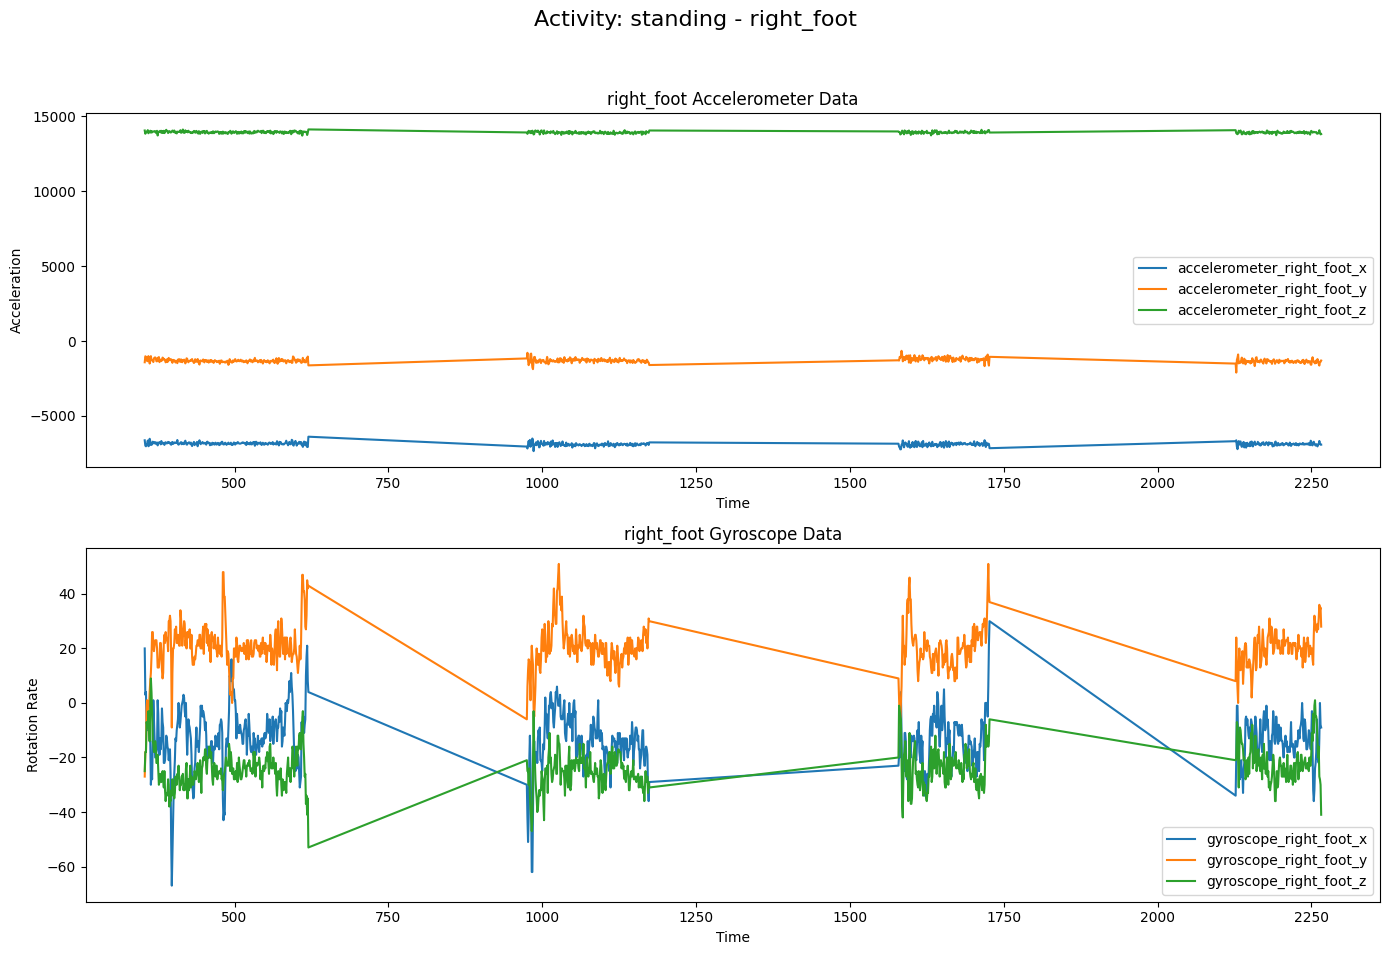

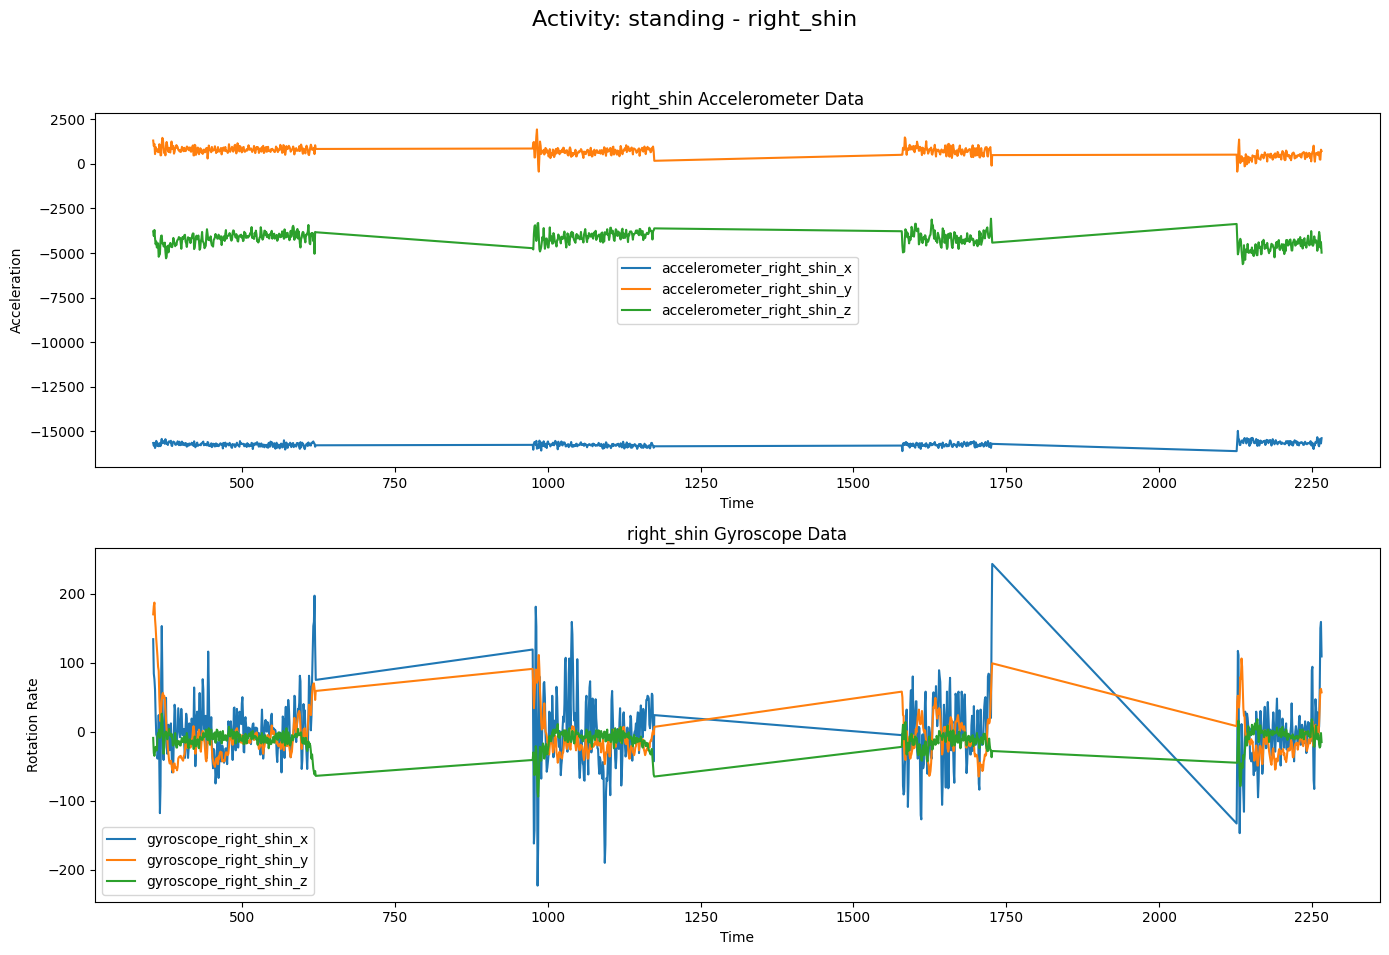

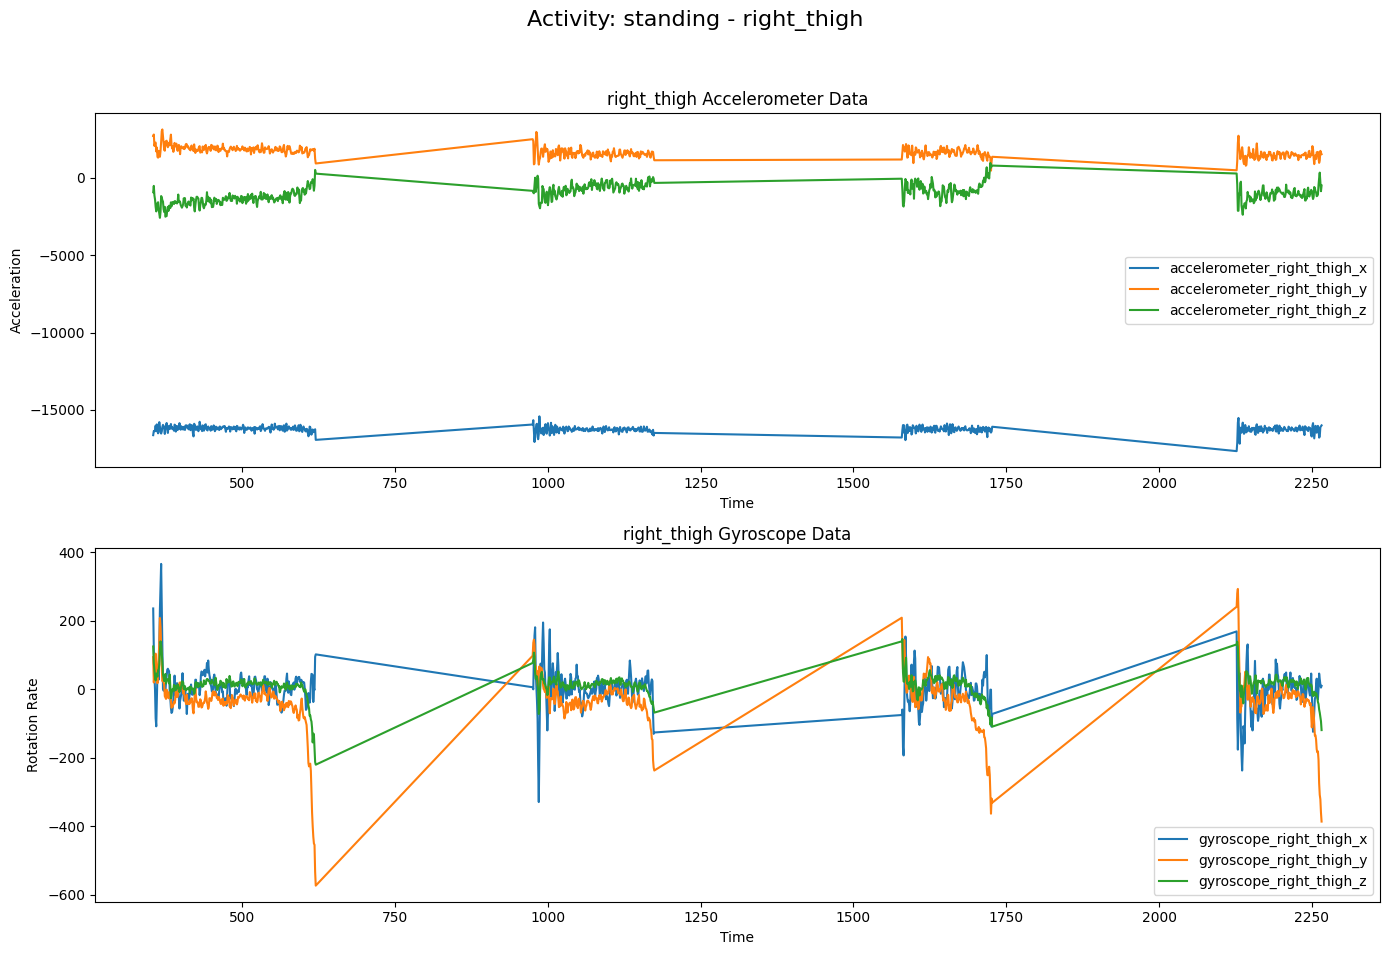

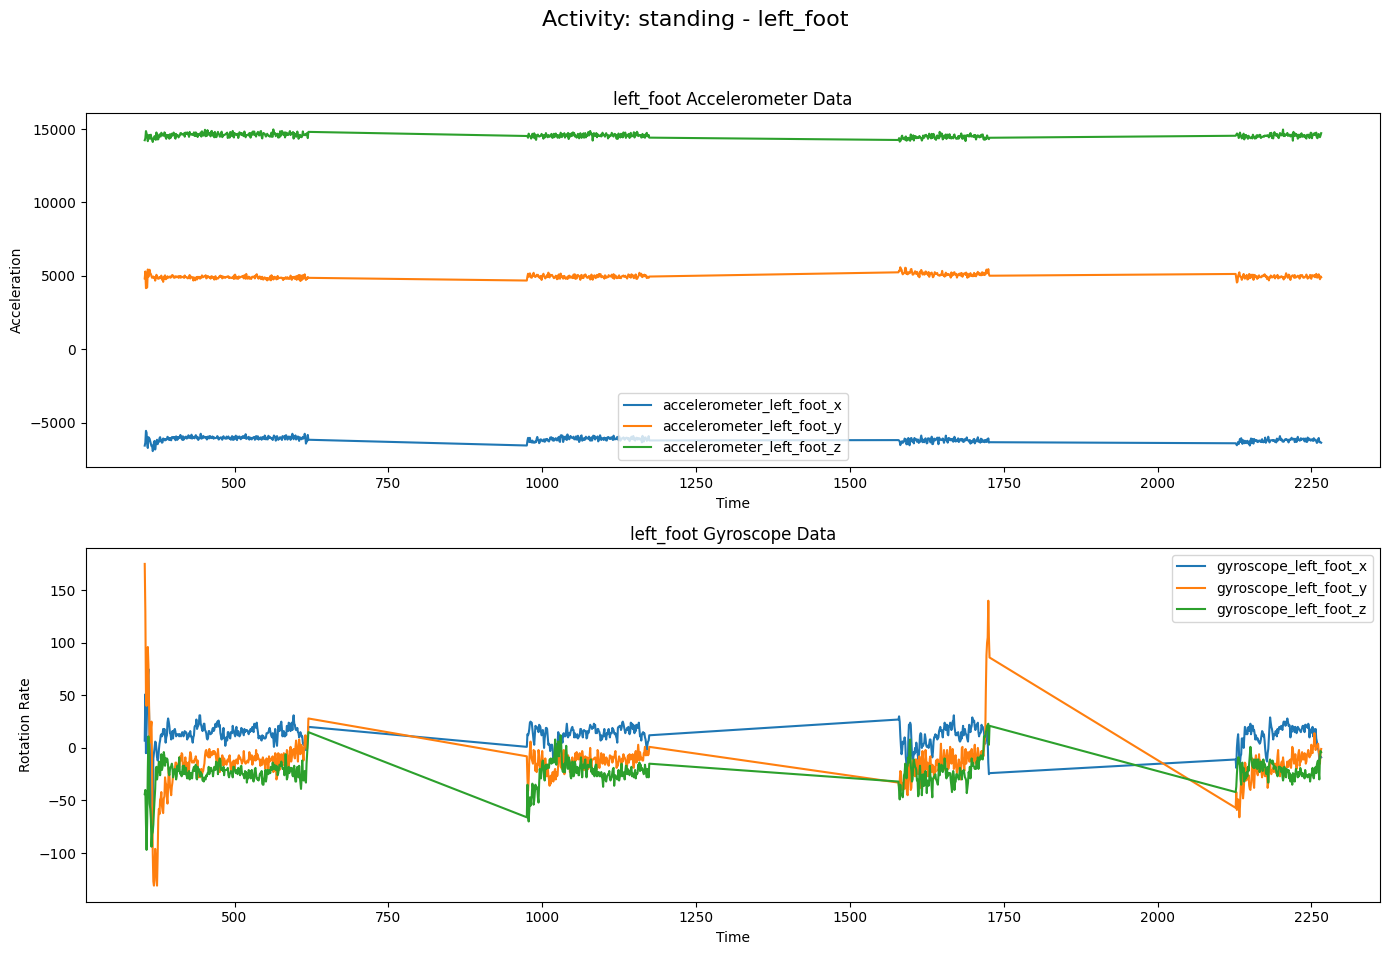

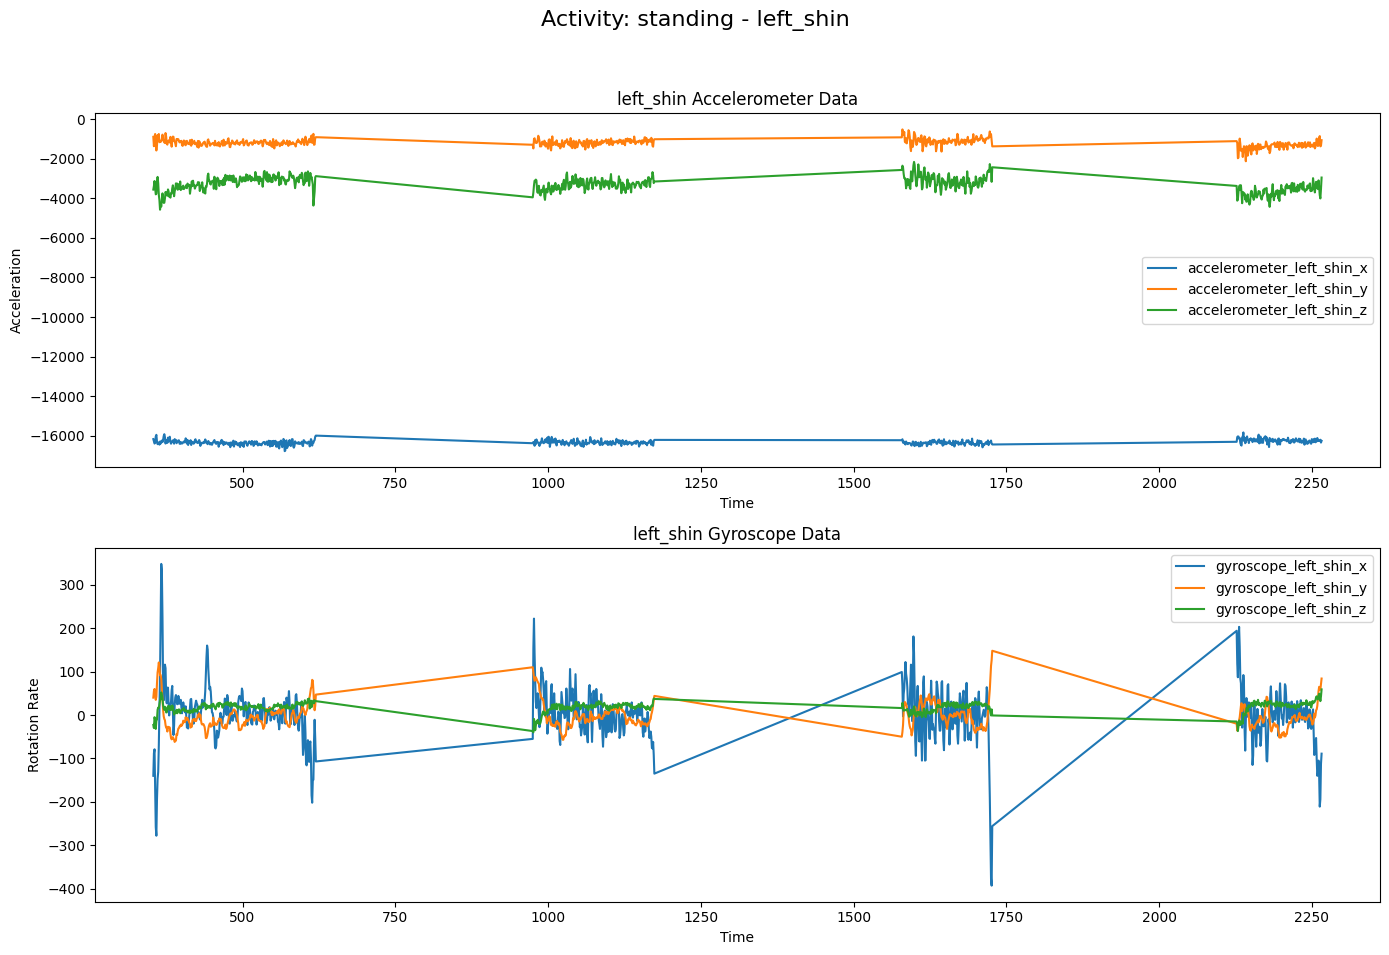

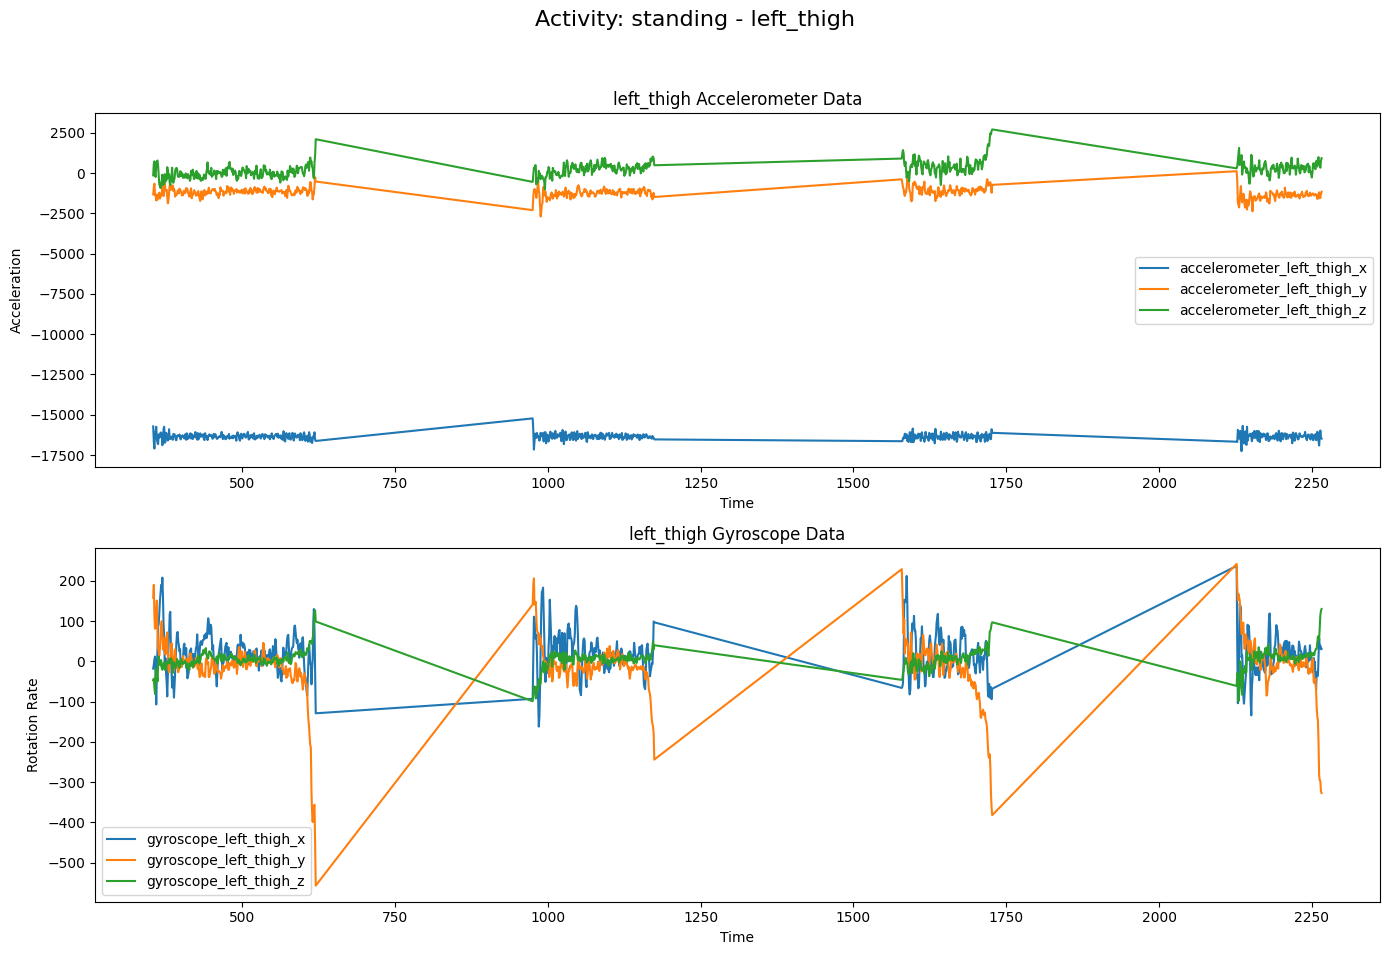

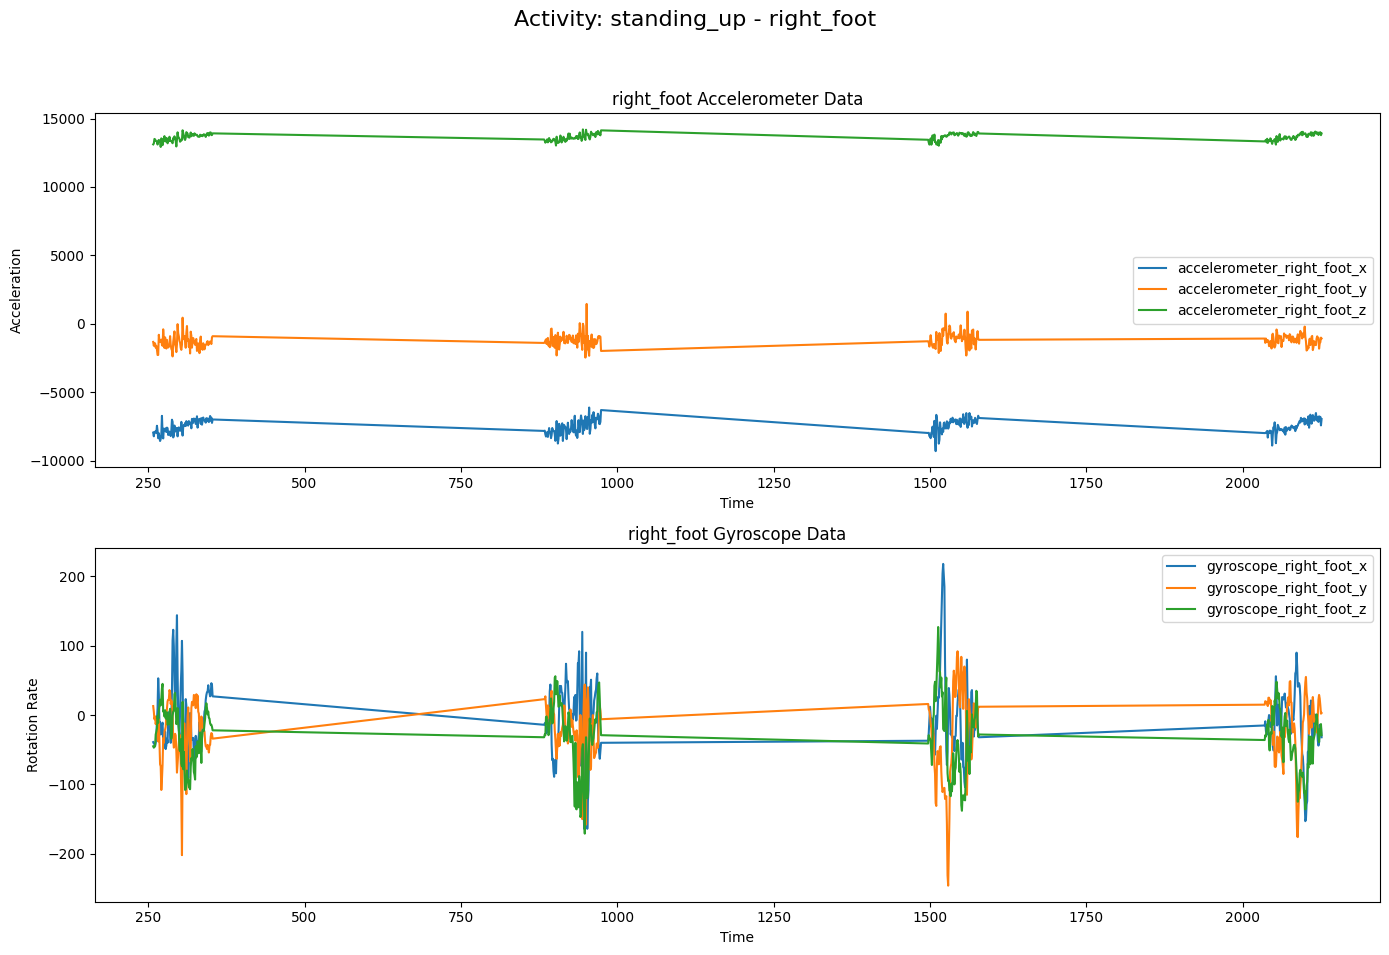

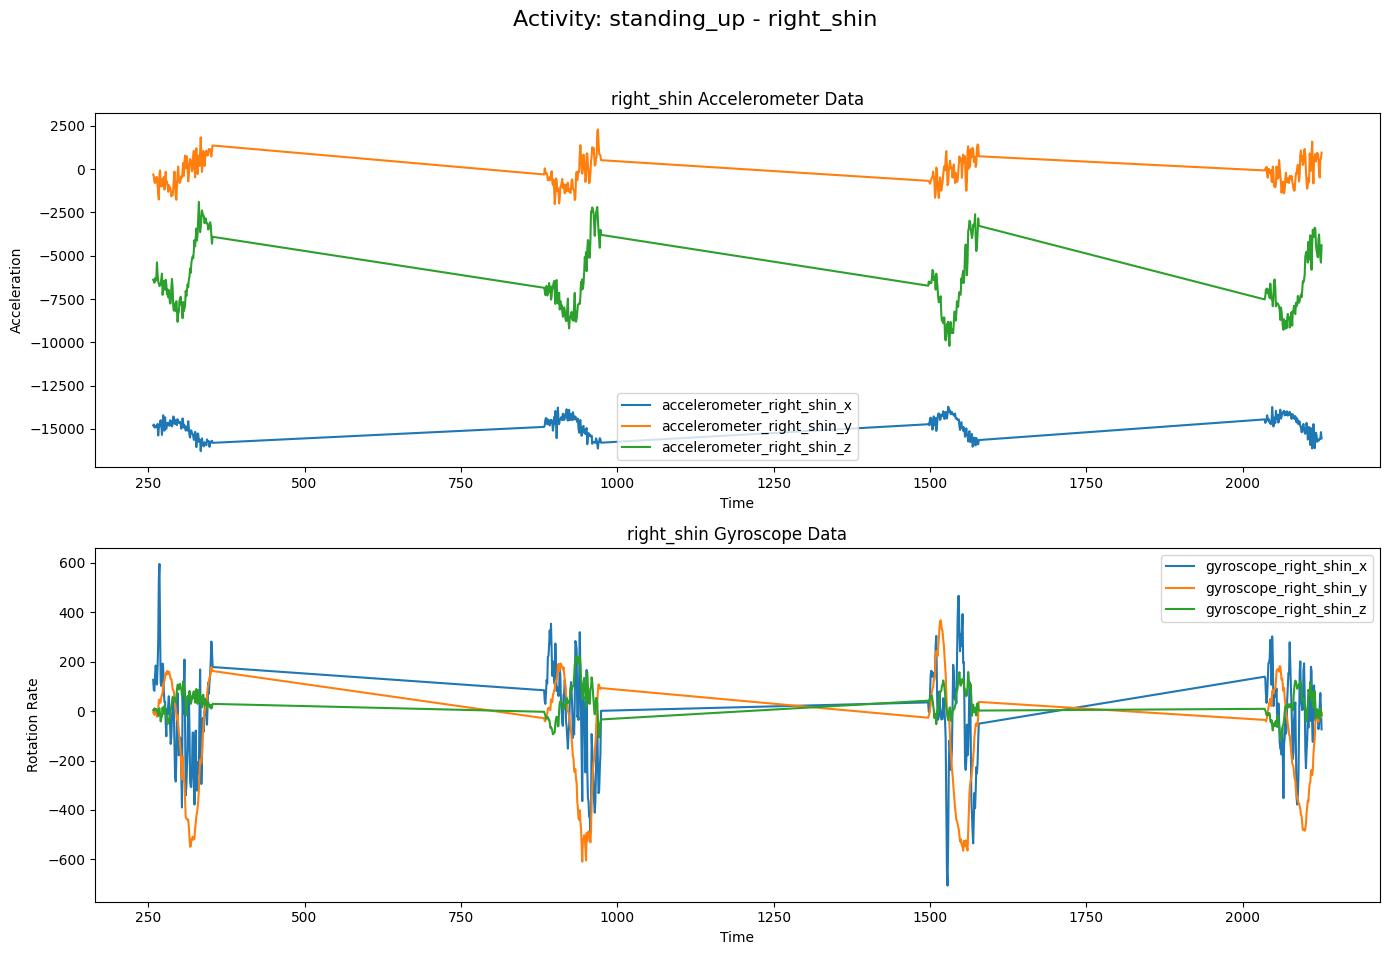

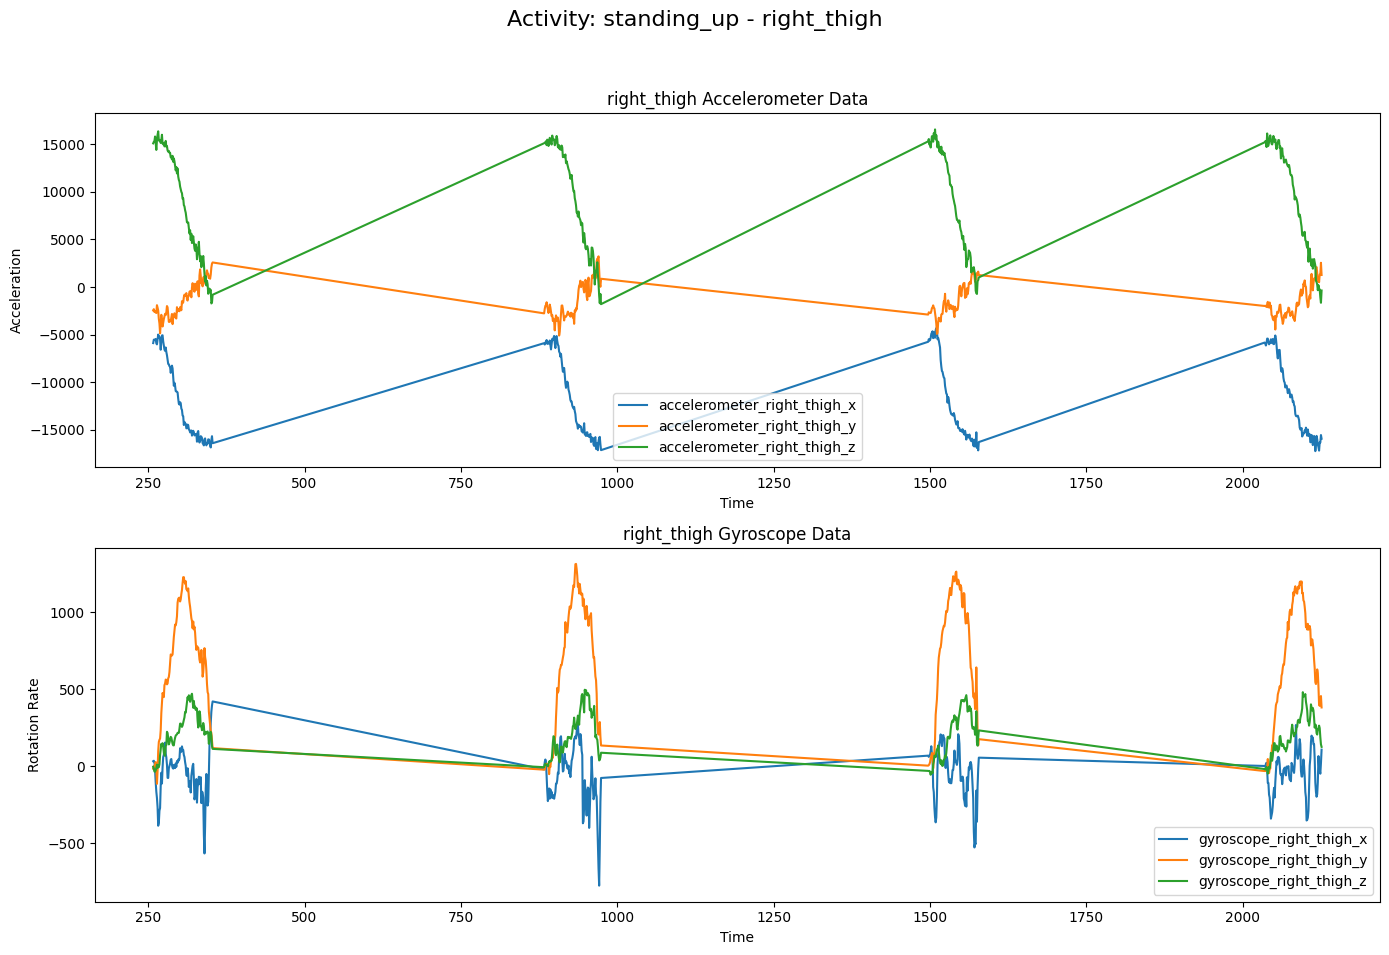

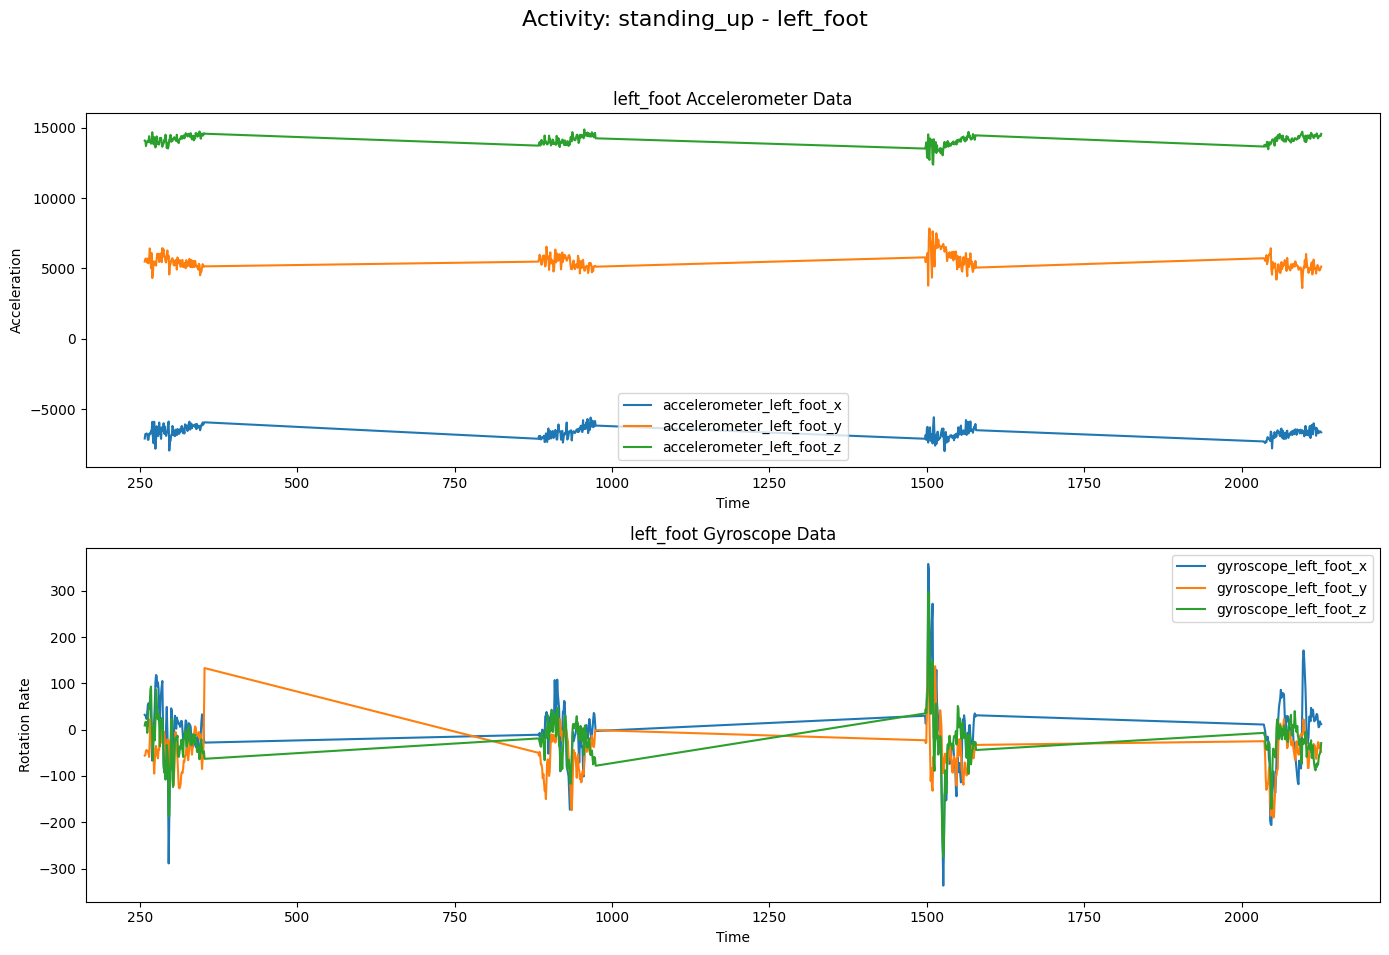

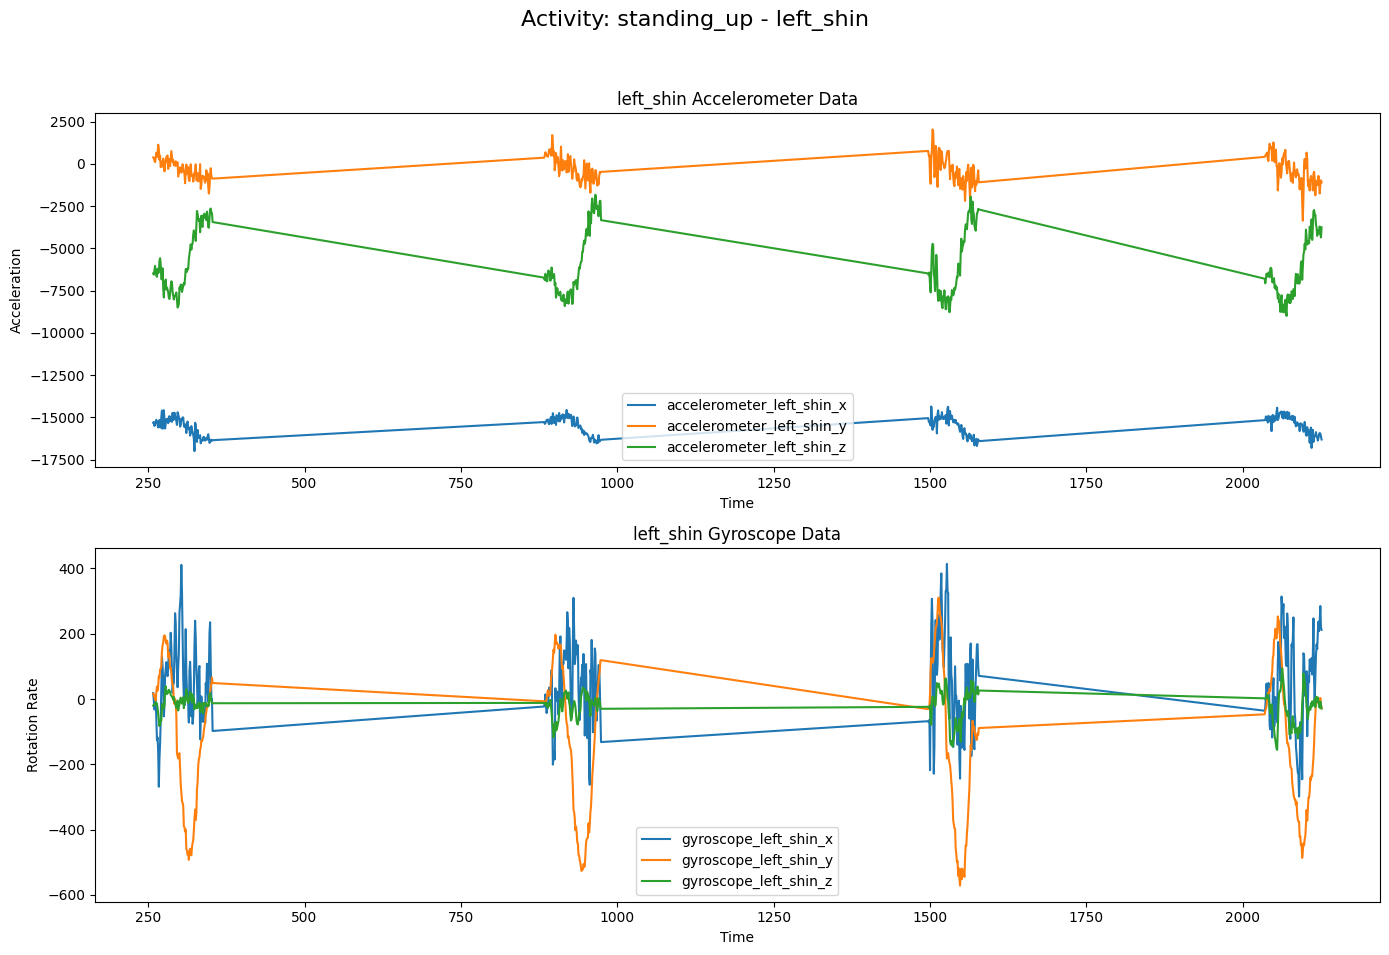

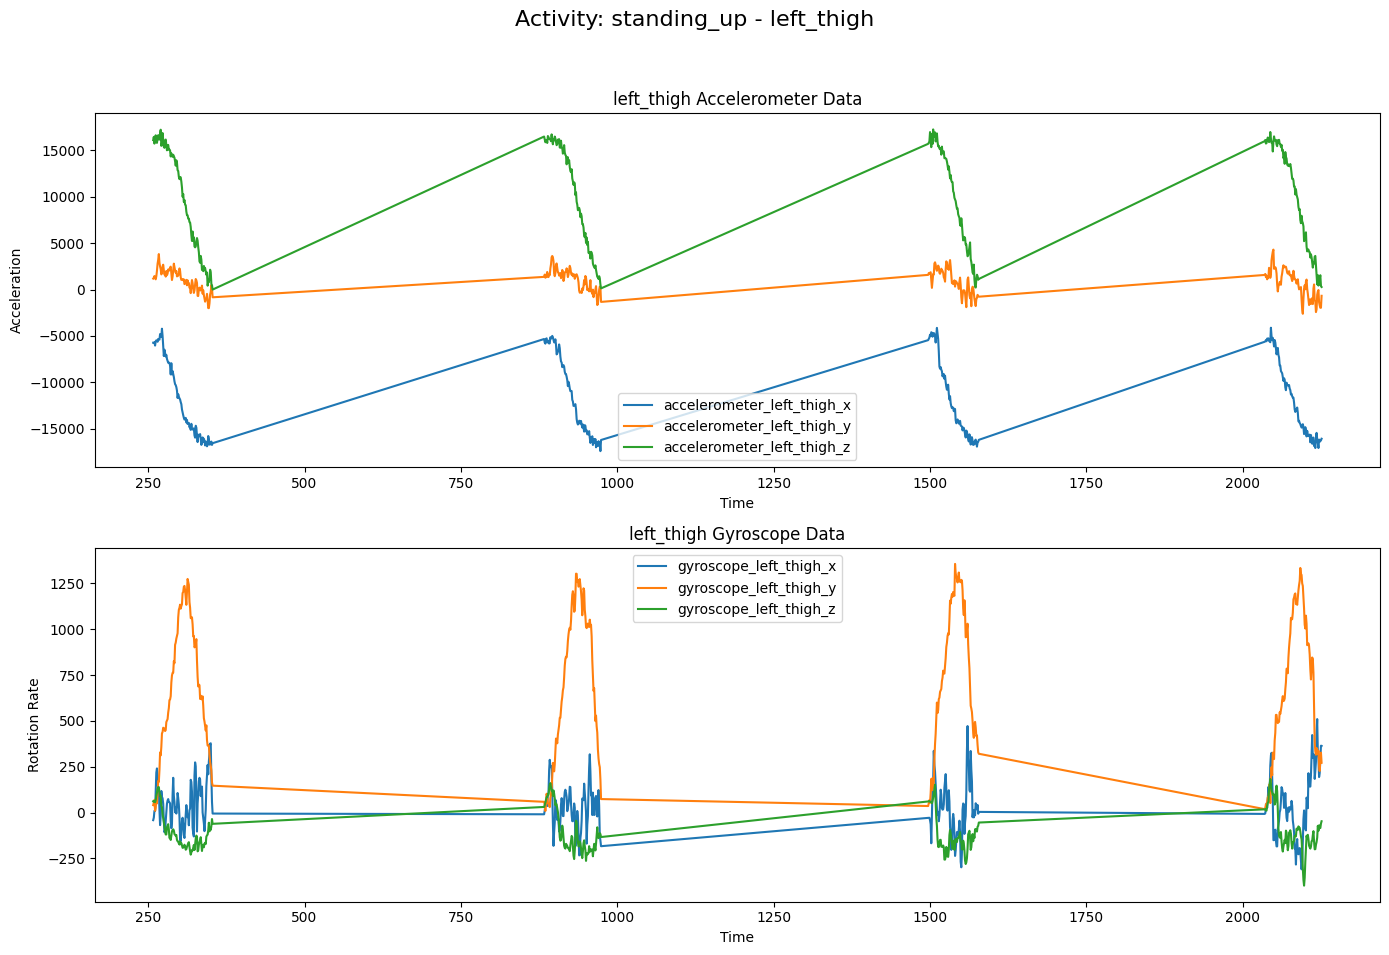

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# função para plotagem dos gráficos, recebendo o dataframe
def plot_sensor_data(df):
    # agrupamento dos sensores, onde temos 6 sensores 
    sensor_groups = {
        'right_foot': ['accelerometer_right_foot_x', 'accelerometer_right_foot_y', 'accelerometer_right_foot_z', 'gyroscope_right_foot_x', 'gyroscope_right_foot_y', 'gyroscope_right_foot_z'],
        'right_shin': ['accelerometer_right_shin_x', 'accelerometer_right_shin_y', 'accelerometer_right_shin_z', 'gyroscope_right_shin_x', 'gyroscope_right_shin_y', 'gyroscope_right_shin_z'],
        'right_thigh': ['accelerometer_right_thigh_x', 'accelerometer_right_thigh_y', 'accelerometer_right_thigh_z', 'gyroscope_right_thigh_x', 'gyroscope_right_thigh_y', 'gyroscope_right_thigh_z'],
        'left_foot': ['accelerometer_left_foot_x', 'accelerometer_left_foot_y', 'accelerometer_left_foot_z', 'gyroscope_left_foot_x', 'gyroscope_left_foot_y', 'gyroscope_left_foot_z'],
        'left_shin': ['accelerometer_left_shin_x', 'accelerometer_left_shin_y', 'accelerometer_left_shin_z', 'gyroscope_left_shin_x', 'gyroscope_left_shin_y', 'gyroscope_left_shin_z'],
        'left_thigh': ['accelerometer_left_thigh_x', 'accelerometer_left_thigh_y', 'accelerometer_left_thigh_z', 'gyroscope_left_thigh_x', 'gyroscope_left_thigh_y', 'gyroscope_left_thigh_z']
    }
    
    grouped = df.groupby('activity')

    for activity, group in grouped:
        for sensor, columns in sensor_groups.items():
            fig, axs = plt.subplots(2, 1, figsize=(14, 10))
            fig.suptitle(f'Activity: {activity} - {sensor}', fontsize=16)

            accel_labels = columns[:3]
            axs[0].plot(group.index, group[accel_labels])
            axs[0].set_title(f'{sensor} Accelerometer Data')
            axs[0].set_xlabel('Time')
            axs[0].set_ylabel('Acceleration')
            axs[0].legend(accel_labels)

            gyro_labels = columns[3:]
            axs[1].plot(group.index, group[gyro_labels])
            axs[1].set_title(f'{sensor} Gyroscope Data')
            axs[1].set_xlabel('Time')
            axs[1].set_ylabel('Rotation Rate')
            axs[1].legend(gyro_labels)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

# plotagem da leitura de todos os sensores do dataframe
plot_sensor_data(df)


In [3]:
import numpy as np
import pandas as pd
from ahrs.filters import Complementary

def complementary_filter(df):
    # inicialização do filtro complementar, gain -> 1 giroscópio, gain -> 0 acelerômetro
    cf = Complementary(frequency=100, gain=0.75)
    
    # grupo dos sensores, seguindo lógica do gráfico
    sensor_groups = {
        'right_foot': ['accelerometer_right_foot_x', 'accelerometer_right_foot_y', 'accelerometer_right_foot_z', 'gyroscope_right_foot_x', 'gyroscope_right_foot_y', 'gyroscope_right_foot_z'],
        'right_shin': ['accelerometer_right_shin_x', 'accelerometer_right_shin_y', 'accelerometer_right_shin_z', 'gyroscope_right_shin_x', 'gyroscope_right_shin_y', 'gyroscope_right_shin_z'],
        'right_thigh': ['accelerometer_right_thigh_x', 'accelerometer_right_thigh_y', 'accelerometer_right_thigh_z', 'gyroscope_right_thigh_x', 'gyroscope_right_thigh_y', 'gyroscope_right_thigh_z'],
        'left_foot': ['accelerometer_left_foot_x', 'accelerometer_left_foot_y', 'accelerometer_left_foot_z', 'gyroscope_left_foot_x', 'gyroscope_left_foot_y', 'gyroscope_left_foot_z'],
        'left_shin': ['accelerometer_left_shin_x', 'accelerometer_left_shin_y', 'accelerometer_left_shin_z', 'gyroscope_left_shin_x', 'gyroscope_left_shin_y', 'gyroscope_left_shin_z'],
        'left_thigh': ['accelerometer_left_thigh_x', 'accelerometer_left_thigh_y', 'accelerometer_left_thigh_z', 'gyroscope_left_thigh_x', 'gyroscope_left_thigh_y', 'gyroscope_left_thigh_z']
    }
    
    orientations_dict = {sensor: [] for sensor in sensor_groups}

    # orientação inicial do quaternion, assumindo que não há rotação no início da leitura
    orientation = np.array([1.0, 0.0, 0.0, 0.0])

    # iteração entre todos os membros do df
    for i in range(len(df)):
        for sensor, columns in sensor_groups.items():
            # dados do acelerômetro e giroscópio, iterando sobre todos os grupos de sensores
            acc = np.array([df.iloc[i][columns[0]], df.iloc[i][columns[1]], df.iloc[i][columns[2]]])
            gyro = np.array([df.iloc[i][columns[3]], df.iloc[i][columns[4]], df.iloc[i][columns[5]]])
            
            # atualização do quaternion, utilizando o quaternion anterior
            orientation = cf.update(orientation, gyr=gyro, acc=acc)
            orientations_dict[sensor].append(orientation)

    # criação do df filtrado
    orientation_dfs = []
    for sensor, orientations in orientations_dict.items():
        orientation_df = pd.DataFrame(orientations, columns=[f'{sensor}_q0', f'{sensor}_q1', f'{sensor}_q2', f'{sensor}_q3'])
        orientation_dfs.append(orientation_df)

    return pd.concat(orientation_dfs, axis=1)

df_filtered = complementary_filter(df)
df_filtered['activity'] = df['activity'].values

print(df_filtered.info())
print(df_filtered.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   right_foot_q0   2435 non-null   float64
 1   right_foot_q1   2435 non-null   float64
 2   right_foot_q2   2435 non-null   float64
 3   right_foot_q3   2435 non-null   float64
 4   right_shin_q0   2435 non-null   float64
 5   right_shin_q1   2435 non-null   float64
 6   right_shin_q2   2435 non-null   float64
 7   right_shin_q3   2435 non-null   float64
 8   right_thigh_q0  2435 non-null   float64
 9   right_thigh_q1  2435 non-null   float64
 10  right_thigh_q2  2435 non-null   float64
 11  right_thigh_q3  2435 non-null   float64
 12  left_foot_q0    2435 non-null   float64
 13  left_foot_q1    2435 non-null   float64
 14  left_foot_q2    2435 non-null   float64
 15  left_foot_q3    2435 non-null   float64
 16  left_shin_q0    2435 non-null   float64
 17  left_shin_q1    2435 non-null   f